In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

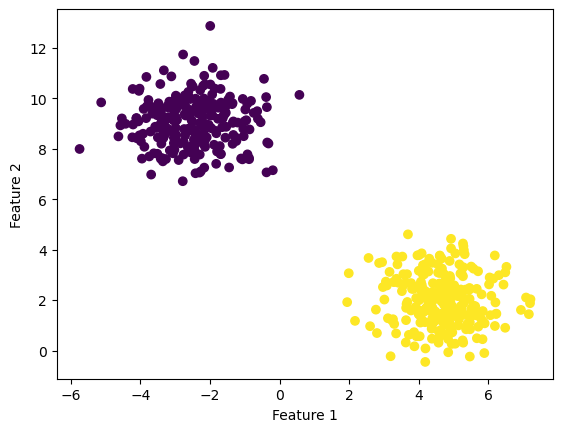

In [2]:
features, targets = make_blobs(n_samples = 500, n_features = 2, centers = 2, random_state = 42)

plt.scatter(features[:, 0], features[:, 1], c = targets)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [9]:
class BinarySVC_LagrangeMultipliers:
    def __init__(self, C = 1.0):
        self.C = C
        self.w = None
        self.b = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.alpha = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y = np.where(y <= 0, -1, 1)

        K = np.dot(X, X.T)

        def objective(alpha):
            return 0.5 * np.sum((y[:, None] * y[None, :]) * K * (alpha[:, None] * alpha[None, :])) - np.sum(alpha)

        def constraint(alpha):
            return np.dot(alpha, y)

        bounds = [(0, self.C) for _ in range(n_samples)]
        constraint = {'type': 'eq', 'fun': constraint}
        result = minimize(objective, np.zeros(n_samples), method='SLSQP', bounds=bounds, constraints=constraint)
        alpha = result.x

        sv = alpha > 1e-5
        self.support_vectors = X[sv]
        self.support_vector_labels = y[sv]
        self.alpha = alpha[sv]

        self.w = np.sum(self.alpha[:, None] * self.support_vector_labels[:, None] * self.support_vectors, axis = 0)
        self.b = np.mean(self.support_vector_labels - np.dot(self.support_vectors, self.w))

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

    def score(self, X, y):
        y = np.where(y <= 0, -1, 1)
        return np.mean(self.predict(X) == y)


In [10]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2)


In [11]:
svc = BinarySVC_LagrangeMultipliers()
svc.fit(x_train, y_train)
print(svc.score(x_test, y_test))

1.0


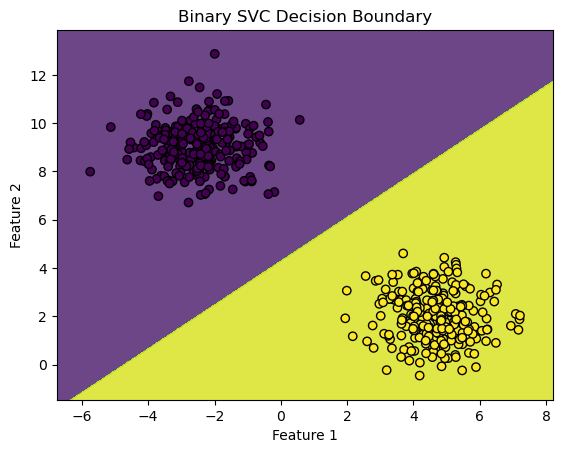

In [7]:
x_min, x_max = features[:, 0].min() - 1, features[:, 0].max() + 1
y_min, y_max = features[:, 1].min() - 1, features[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha = 0.8)
plt.scatter(features[:, 0], features[:, 1], c = targets, edgecolor = 'black')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# شرح تفصيلي لتنفيذ SVM مع المعادلات

## 1. تهيئة البيانات

```python
n_samples, n_features = X.shape
y = np.where(y <= 0, -1, 1)
K = np.dot(X, X.T)
```

في هذا الجزء، نقوم بتهيئة البيانات:
- نحصل على عدد العينات وعدد الخصائص من `X`.
- نتأكد من أن التصنيفات `y` هي -1 و 1.
- نحسب مصفوفة Gram `K`، حيث $K_{ij} = x_i \cdot x_j$.

المعادلة الرياضية لمصفوفة Gram:

$$K_{ij} = x_i \cdot x_j$$

## 2. تعريف دالة الهدف

```python
def objective(alpha):
    return 0.5 * np.sum((y[:, None] * y[None, :]) * K * (alpha[:, None] * alpha[None, :])) - np.sum(alpha)
```

هذه الدالة تمثل الصيغة الثنائية لمشكلة التحسين في SVM. 

المعادلة الرياضية:

$$L(\alpha) = \sum_{i=1}^{n} \alpha_i - \frac{1}{2} \sum_{i=1}^{n} \sum_{j=1}^{n} y_i y_j \alpha_i \alpha_j K(x_i, x_j)$$

حيث:
- $\alpha_i$ هي مضاعفات لاغرانج التي نحاول إيجادها.
- $y_i$ هي تصنيفات البيانات.
- $K(x_i, x_j)$ هي دالة النواة (في حالتنا، الضرب النقطي البسيط).

## 3. تعريف القيد

```python
def constraint(alpha):
    return np.dot(alpha, y)
```

هذا القيد يضمن أن مجموع $\alpha_i y_i$ يساوي صفر.

المعادلة الرياضية:

$$\sum_{i=1}^{n} \alpha_i y_i = 0$$

## 4. تحديد الحدود وحل مشكلة التحسين

```python
bounds = [(0, self.C) for _ in range(n_samples)]
constraint = {'type': 'eq', 'fun': constraint}
result = minimize(objective, np.zeros(n_samples), method='SLSQP', bounds=bounds, constraints=constraint)
alpha = result.x
```

هنا نحدد الحدود لقيم $\alpha$ (بين 0 و C) ونستخدم دالة `minimize` لحل مشكلة التحسين.

القيود الرياضية:

$$0 \leq \alpha_i \leq C, \quad i = 1, \ldots, n$$

## 5. تحديد المتجهات الداعمة

```python
sv = alpha > 1e-5
self.support_vectors = X[sv]
self.support_vector_labels = y[sv]
self.alpha = alpha[sv]
```

نحدد المتجهات الداعمة كالنقاط التي لها قيم $\alpha$ أكبر من عتبة صغيرة (1e-5).

## 6. حساب متجه الوزن w

```python
self.w = np.sum(self.alpha[:, None] * self.support_vector_labels[:, None] * self.support_vectors, axis=0)
```

نحسب متجه الوزن w باستخدام المتجهات الداعمة.

المعادلة الرياضية:

$$w = \sum_{i \in SV} \alpha_i y_i x_i$$

حيث SV هي مجموعة المتجهات الداعمة.

## 7. حساب الانحياز b

```python
self.b = np.mean(self.support_vector_labels - np.dot(self.support_vectors, self.w))
```

نحسب الانحياز b باستخدام متوسط الفرق بين تصنيفات المتجهات الداعمة وناتج ضرب المتجهات الداعمة مع w.

المعادلة الرياضية:

$$b = \frac{1}{|SV|} \sum_{i \in SV} (y_i - w \cdot x_i)$$

حيث |SV| هو عدد المتجهات الداعمة.

## الخلاصة

هذه الخطوات تنفذ خوارزمية SVM باستخدام طريقة مضاعفات لاغرانج. نبدأ بصياغة المشكلة كمسألة تحسين ثنائية، ثم نحلها للحصول على قيم $\alpha$. بعد ذلك، نستخدم هذه القيم لحساب متجه الوزن w والانحياز b، اللذين يحددان المستوى الفاصل الأمثل بين الفئتين.